In [1]:
# Importation des librairies

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import scipy.stats as st
from scipy.stats import jarque_bera
from tabulate import tabulate
from pathlib import Path
from unidecode import unidecode
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import jarque_bera, durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, lasso_path
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    make_scorer,
)
from sklearn.metrics.cluster import v_measure_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    Binarizer,
    StandardScaler,
    FunctionTransformer,
    label_binarize,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    TunedThresholdClassifierCV,
)

In [2]:
def description_variables(df):

    """
    Résume les informations principales d'un DataFrame, y compris les types de colonnes,
    les valeurs uniques, les valeurs manquantes et leur pourcentage.

    Paramètres :
    ----------
    df : pandas.DataFrame
        Le DataFrame dont on souhaite résumer les informations.

    Retours :
    -------
    pandas.DataFrame
        Un DataFrame contenant les informations suivantes pour chaque colonne :
        - type : Le type de la colonne.
        - total : Nombre total de lignes dans le DataFrame.
        - n : Nombre de valeurs non manquantes par colonne.
        - unique : Nombre de valeurs uniques par colonne.
        - NaN : Nombre de valeurs manquantes par colonne.
        - pourcentage_(NaN) : Pourcentage de valeurs manquantes par colonne (arrondi à 2 décimales).

    Notes :
    ------
    - Le DataFrame de sortie est trié par le pourcentage de valeurs manquantes (ordre décroissant).
    - La fonction affiche également un résumé général du jeu de données :
      nombre de lignes et de colonnes.

    """

    # Afficher le type de la variable
    type_variable = df.dtypes

    # Nombre de lignes totales
    nb_lignes = len(df.index)

    # Nombre total de valeurs dans chaque colonne
    total_values = df.count()

    # Nombre de valeurs uniques dans chaque colonnes
    valeurs_uniques = df.nunique()

    # Calculer le nombre de valeurs manquantes pour chaque colonne
    missing_counts = df.isnull().sum()

    # Calculer le pourcentage de valeurs manquantes pour chaque colonne
    missing_percentage = (missing_counts / df.shape[0] * 100).round(2)

    # Créer un DataFrame avec les résultats
    variables_infos = pd.DataFrame(
        {
            "type": type_variable,
            "total": nb_lignes,
            "n": total_values,
            "unique": valeurs_uniques,
            #'doublons' : nb_doublons,
            "NaN": missing_counts,
            "pourcentage_(NaN)": missing_percentage,
        }
    )

    # Trier par 'pourcentage_(NaN)' dans l'ordre décroissant
    variables_infos = variables_infos.sort_values(
        by="pourcentage_(NaN)", ascending=False
    )

    print("Description donnée(s):")
    print("Le jeu de données comporte: {} observation(s)".format(df.shape[0]))
    print("Le jeu de données comporte: {} colonne(s)".format(df.shape[1]))

    return variables_infos

In [3]:
# Limiter les threads pour éviter l'avertissement KMeans
os.environ["OMP_NUM_THREADS"] = "5"


class StaticLinearRegressionImputer(BaseEstimator, TransformerMixin):

    """
    Impute les valeurs manquantes dans une colonne cible en utilisant une régression linéaire multiple.

    Cette classe est une implémentation personnalisée de scikit-learn qui permet d'imputer les valeurs
    manquantes d'une colonne cible (`target_column`) à l'aide d'un modèle de régression linéaire
    entraîné sur les colonnes prédictrices spécifiées (`predictor_columns`).

    Attributs :
    ----------
    target_column : str
        Nom de la colonne cible contenant des valeurs manquantes à imputer.

    predictor_columns : list of str, optional
        Liste des noms des colonnes prédictrices utilisées pour entraîner le modèle de régression.

    model : LinearRegression
        Modèle de régression linéaire utilisé pour effectuer les imputations.

    selected_features : list of str
        Liste des colonnes prédictrices sélectionnées après l'entraînement.

    r2_score_ : float
        Coefficient de détermination (R²) du modèle sur les données d'entraînement.

    mae_ : float
        Erreur absolue moyenne (Mean Absolute Error, MAE) sur les données d'entraînement.

    mse_ : float
        Erreur quadratique moyenne (Mean Squared Error, MSE) sur les données d'entraînement.

    rmse_ : float
        Racine carrée de l'erreur quadratique moyenne (Root Mean Squared Error, RMSE) sur les données d'entraînement.

    missing_before_ : int
        Nombre de valeurs manquantes dans la colonne cible avant la transformation.

    missing_after_ : int
        Nombre de valeurs manquantes dans la colonne cible après la transformation.

    Méthodes :
    ---------
    fit(X, y=None)
        Entraîne le modèle de régression linéaire en utilisant les colonnes prédictrices
        pour estimer la colonne cible inversée (1/valeur cible).

    transform(X)
        Impute les valeurs manquantes dans la colonne cible en utilisant les prédictions du modèle.
        
    """

    def __init__(self, target_column, predictor_columns=None):
        self.target_column = target_column
        self.predictor_columns = predictor_columns
        self.model = LinearRegression()
        self.selected_features = None
        self.r2_score_ = None
        self.mae_ = None
        self.mse_ = None
        self.rmse_ = None
        self.missing_before_ = 0
        self.missing_after_ = 0

    def fit(self, X, y=None):
        if not self.predictor_columns:
            raise ValueError("Les colonnes prédictrices doivent être spécifiées.")

        # Créer une copie explicite pour éviter SettingWithCopyWarning
        complete_data = X.dropna(subset=[self.target_column]).copy()
        complete_data["margin_low_inverse"] = 1 / complete_data[self.target_column]

        y_train = complete_data["margin_low_inverse"]
        X_train = complete_data[self.predictor_columns]

        self.selected_features = self.predictor_columns
        self.model.fit(X_train, y_train)

        y_pred = self.model.predict(X_train)
        self.r2_score_ = r2_score(y_train, y_pred)
        self.mae_ = mean_absolute_error(y_train, y_pred)
        self.mse_ = mean_squared_error(y_train, y_pred)
        self.rmse_ = np.sqrt(self.mse_)

        return self

    def transform(self, X):
        X_transformed = X.copy()

        self.missing_before_ = X[self.target_column].isna().sum()

        incomplete_data = X_transformed[X_transformed[self.target_column].isna()]
        if not incomplete_data.empty:
            predicted_margin_low_inverse = self.model.predict(
                incomplete_data[self.selected_features]
            )
            X_transformed.loc[incomplete_data.index, self.target_column] = (
                1 / predicted_margin_low_inverse
            )

        self.missing_after_ = X_transformed[self.target_column].isna().sum()

        return X_transformed

In [4]:
# Changement de dossier
os.chdir(
    r"C:\Users\jerem\OneDrive\EMPLOI\PôleEmploi\Formation\Data Analyst\Openclassroom\Mes projets\Projet 12\oncfm"
)

# Chargement des données
try:
    df_billets_production = pd.read_csv("billets_production.csv", sep=",")
    print("Données chargées avec succès.")
    print(
        f"Le DataFrame contient {df_billets_production.shape[0]} lignes et {df_billets_production.shape[1]} colonnes."
    )
except FileNotFoundError:
    print(
        "Erreur : le fichier 'billets_production.csv' est introuvable dans le répertoire actuel."
    )
except Exception as e:
    print(f"Une erreur s'est produite lors du chargement des données : {e}")

Données chargées avec succès.
Le DataFrame contient 5 lignes et 7 colonnes.


In [5]:
# Charger le modèle sauvegardé
try:
    loaded_pipeline = joblib.load("logit_pipeline.pkl")
    print(
        "Le pipeline avec un modèle de Régression Logistique a été chargé avec succès."
    )
    print(type(loaded_pipeline))  # Ajout pour afficher le type de l'objet chargé
except FileNotFoundError:
    print(
        "Erreur : le modèle 'logit_pipeline' est introuvable dans le répertoire actuel."
    )
except Exception as e:
    print(f"Une erreur s'est produite lors du chargement du modèle : {e}")

Le pipeline avec un modèle de Régression Logistique a été chargé avec succès.
<class 'sklearn.pipeline.Pipeline'>


In [6]:
# Afficher toutes les colonnes d'un dataframe
pd.set_option("display.max_columns", None)

In [7]:
# Afficher les premières lignes du dataframe
df_billets_production.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [8]:
# Supprimer la colonne id
df_billets_production = df_billets_production.drop("id", axis=1)

# Description du jeu de données
description_variables(df_billets_production)

Description donnée(s):
Le jeu de données comporte: 5 observation(s)
Le jeu de données comporte: 6 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
diagonal,float64,5,5,5,0,0.0
height_left,float64,5,5,5,0,0.0
height_right,float64,5,5,5,0,0.0
margin_low,float64,5,5,5,0,0.0
margin_up,float64,5,5,5,0,0.0
length,float64,5,5,5,0,0.0


In [9]:
# Afficher les statistiques descriptives
df_billets_production.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,171.954000,104.188000,103.972000,4.882000,3.238000,112.322000
std,0.326542,0.396257,0.393027,0.836821,0.142724,0.897201
min,171.650000,103.630000,103.540000,3.770000,3.030000,111.420000
25%,171.760000,104.010000,103.560000,4.440000,3.160000,111.570000
50%,171.870000,104.170000,104.130000,4.990000,3.300000,112.090000
75%,172.000000,104.550000,104.290000,5.210000,3.310000,113.200000
max,172.490000,104.580000,104.340000,6.000000,3.390000,113.330000


In [10]:
# Utiliser le modèle pour prédire
y_pred_new = loaded_pipeline.predict(df_billets_production)
print("Prédictions effectuées avec le pipeline chargé.")

Prédictions effectuées avec le pipeline chargé.


In [11]:
# Ajouter une colonne 'id' pour référence car elle a été supprimée
df_billets_production["id"] = range(1, len(df_billets_production) + 1)


# Parcourir les prédictions et afficher les résultats
for billet_id, prediction in zip(df_billets_production["id"], y_pred_new):
    if prediction == 1:
        print(f"Le billet ref. {billet_id} est un vrai billet.")
    else:
        print(f"Le billet ref. {billet_id} est un faux billet.")

Le billet ref. 1 est un faux billet.
Le billet ref. 2 est un faux billet.
Le billet ref. 3 est un faux billet.
Le billet ref. 4 est un vrai billet.
Le billet ref. 5 est un vrai billet.


In [12]:
# Ajouter une colonne au DataFrame avec True pour "vrai billet" et False pour "faux billet"
df_billets_production["is_genuine"] = y_pred_new == 1

# Afficher les premières lignes pour vérifier
df_billets_production.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,5,True


In [13]:
df_true = df_billets_production.loc[df_billets_production["is_genuine"] == True]
df_true

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine
3,172.49,104.55,104.34,4.44,3.03,113.20,4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,5,True


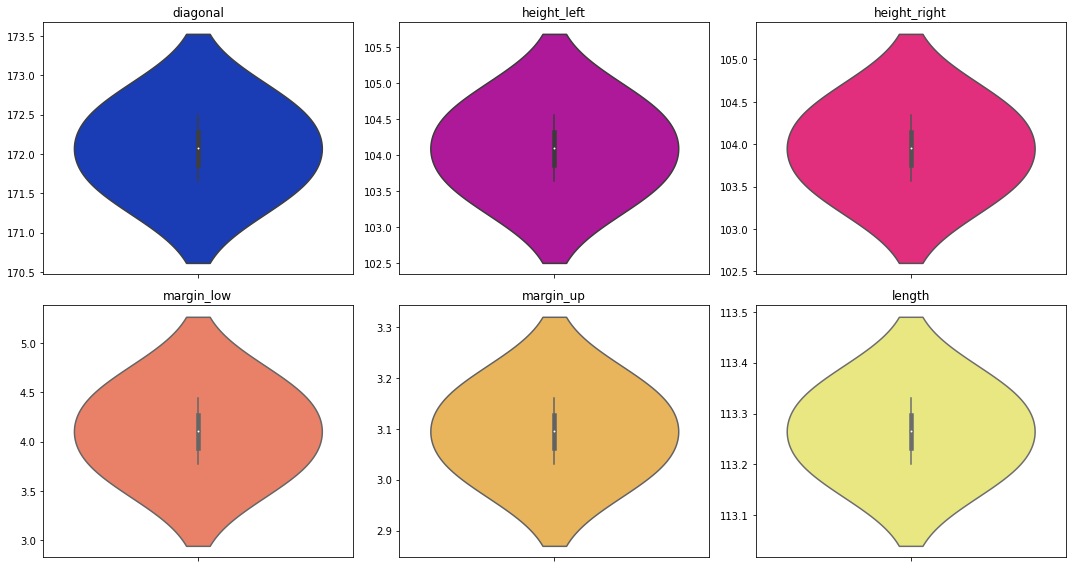

In [14]:
# Afficher les violinplot pour chaque variables des vrais billets

# Variables quantitatives
quantitative_vars = [
    "diagonal",
    "height_left",
    "height_right",
    "margin_low",
    "margin_up",
    "length",
]

# Création des sous-graphiques
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
axes = axes.flatten()  # Aplatir les axes pour itérer facilement

# Palette par défaut ou personnalisée
color = [
    "#002fd0",
    "#c600ab",
    "#ff117a",
    "#ff7452",
    "#ffbb46",
    "#f9f871",
]  # Palette personnalisée

for i, (var, color) in enumerate(zip(quantitative_vars, color)):
    sns.violinplot(
        data=df_true,
        y=var,
        ax=axes[i],
        color=color,  # Une couleur unique pour chaque graphique
        inner="box",  # Montre la boîte des percentiles
        scale="width",  # Ajuste la largeur en fonction de la densité
    )
    axes[i].set_title(var, fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Supprimer les axes inutilisés si le nombre de variables < nrows * ncols
for j in range(len(quantitative_vars), len(axes)):
    fig.delaxes(axes[j])

# Ajustement des espacements
plt.tight_layout()
plt.show()

In [15]:
df_false = df_billets_production.loc[df_billets_production["is_genuine"] == False]
df_false

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,3,False


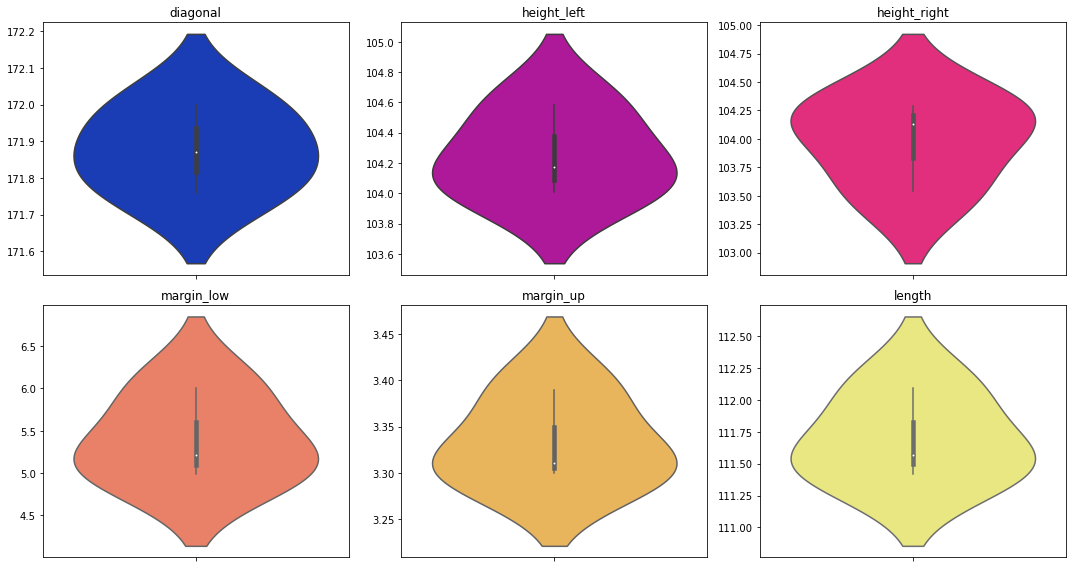

In [16]:
# Afficher les violinplot pour chaque variables des faux billets

# Variables quantitatives
quantitative_vars = [
    "diagonal",
    "height_left",
    "height_right",
    "margin_low",
    "margin_up",
    "length",
]

# Création des sous-graphiques
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
axes = axes.flatten()  # Aplatir les axes pour itérer facilement

# Palette par défaut ou personnalisée
color = [
    "#002fd0",
    "#c600ab",
    "#ff117a",
    "#ff7452",
    "#ffbb46",
    "#f9f871",
]  # Palette personnalisée

for i, (var, color) in enumerate(zip(quantitative_vars, color)):
    sns.violinplot(
        data=df_false,
        y=var,
        ax=axes[i],
        color=color,  # Une couleur unique pour chaque graphique
        inner="box",  # Montre la boîte des percentiles
        scale="width",  # Ajuste la largeur en fonction de la densité
    )
    axes[i].set_title(var, fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Supprimer les axes inutilisés si le nombre de variables < nrows * ncols
for j in range(len(quantitative_vars), len(axes)):
    fig.delaxes(axes[j])

# Ajustement des espacements
plt.tight_layout()
plt.show()